# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## [Final Project] Social Media Toxicity Shield: Milestone 5


**Harvard University**<br/>
**Spring 2025**<br/>
**Team**: Amar Boparai, Andrew Lobo, Conrad Kaminski, Xiaoxuan Zhang, Xuanthe Nguyen<br/>
**Canvas Project Group**: 31

<hr style="height:2pt">

In [1]:
# Library Imports
import os
import pickle
import re
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from collections import Counter\

from tensorflow import keras
from keras.models import Model, Sequential, load_model
from keras import layers
from keras import losses
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Precision, Recall, MeanIoU, AUC, BinaryAccuracy
from keras.layers import Input, Embedding, SimpleRNN, GRU, LSTM, TimeDistributed, Bidirectional, Dense
from keras.layers import  BatchNormalization, Activation, Dropout, GaussianNoise
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import backend as K

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.cluster import KMeans

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
import evaluate
import numpy as np
import torch
import pandas as pd


2025-04-28 23:43:08.089659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-28 23:43:08.089703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-28 23:43:08.090495: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-28 23:43:08.095809: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Issues with the below imports on my local machine—will likely resort to JupyterHub
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFDebertaV2ForSequenceClassification
from transformers import TFBertPreTrainedModel, TFBertMainLayer

os.environ['TF_CPP_MIN_LOG_LEVEL']='2' # Trying to reduce tensorflow warnings
os.environ['TF_GPU_ALLOCATOR'] = "cuda_malloc_async"

<a id="contents"></a>
# Table of Contents
1. [**Problem Statement Refinement and Introduction**](#intro)
2. [**Comprehensive EDA Review**](#eda)
    - [**Key EDA Findings**](#find)
    - [**Initial Preprocessing**](#preprocess1)
    - [**Additional Preprocessing**](#preprocess2)
3. [**Modeling**](#model)
    - [**Baseline Model Choice**](#choice)
    - [**Training Process**](#train)
    - [**Initial Results**](#result)
4. [**Results Interpretation & Analysis**](#interp)
    - [**Analysis of Baseline Model Performance**](#analysis)
    - [**Proposed Improvements**](#improve)
5. [**Final Model Pipeline**](#final)
    - [**Assumptions, Parameter Choices, and Preliminary Tuning Considerations**](#assum)

<a id="intro"></a>

# 1. Problem Statement Refinement and Introduction

[Return to contents](#contents)

## Introduction
Online platforms vary widely in functionality and purpose, yet they all face a common problem: toxic content. Harmful posts can negatively impact users’ well-being—contributing to anxiety, depression, and other mental-health issues—and rely heavily on human moderators to keep forums safe. Although many platforms censor slurs or profanity, toxicity often goes beyond “bad words.” With today’s advanced tools, we have an opportunity to monitor—and mitigate—toxicity more effectively.

As a reminder, we’re using the Jigsaw Unintended Bias in Toxicity Classification dataset from [Kaggle](https://www.kaggle.com/datasets/julian3833/jigsaw-multilingual-toxic-comment-classification), which contains approximately 1.9 million comments labeled for various forms of toxicity.

## Problem Statement
- **Primary goal:** How can we reliably predict the toxicity of online comments?  
- **Secondary goals:** Which features contribute most to toxicity, and how can we assess our model’s fairness across different identity attributes?  
  In particular, many comments containing identity markers are labeled toxic more often than not—so we need to ensure our model can accurately detect toxicity regardless of such markers.

## Addressing Prior Feedback
Our earlier approach involved oversampling the minority (toxic) class, then applying a penalty to minority-class predictions—a contradictory strategy. We’ve removed that penalty to align sampling and loss functions.

## Adjusted Significance
Our earlier EDA reveals a severe class imbalance: non-toxic comments far outnumber toxic ones. To address this, we’ll optimize not only for overall accuracy but also for precision and recall—ensuring each class is identified correctly. We also take reassurance in knowing that toxic comments comprise only a small fraction of the dataset.


<a id="eda"></a>

# 2. Comprehensive EDA Review
[Return to contents](#contents)

<a id="find"></a>

## Key EDA Findings

[Return to contents](#contents)

- The most frequent words in toxic comments often have political connotations or express societal opinions (e.g., “people,” “state”). 
    - This doesn’t impact our feature engineering—just an interesting observation.  
- There is a significant class imbalance in the `toxic` class, as well as in most other variables (except `insult`):  
  - We combined the `severe_toxic` and `toxic` labels, since both capture the outcome we care about—whether a comment is toxic.  
  - To keep our training corpus robust, we will upsample toxic comments
  - When we have more time, we would also leverage a GPT-based generator to introduce more variety into the positive class.  
- The `insult` and `toxic` labels are highly correlated (0.75), while `toxic` shows only weak correlations with other predictors—another obvious but noteworthy point: toxicity often manifests as insults.  
- Most comments are under 250 characters, with frequency decaying exponentially until around 1,000 characters, where there’s a slight uptick (see image below). 
    - This pattern likely won’t affect feature extraction, but it may guide our choice of maximum sequence length for the tokenizer.

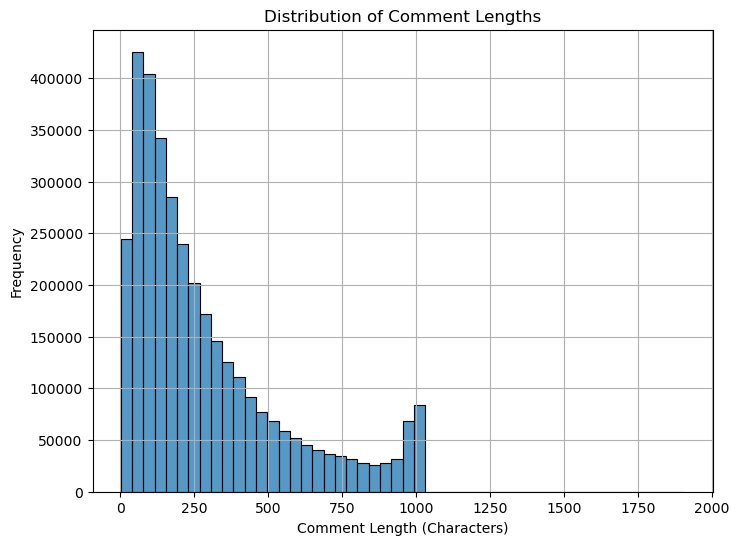

---

<a id="preprocess1"></a>

## Initial Preprocessing (MS2 & MS3)
[Return to contents](#contents)

1. [MS2] We only focused on the columns that provided an indication of toxicity, removing columns such as those related to identity or metadata. 
2. [MS2] After subsetting the data, less than 0.001% of the data was missing, so we dropped the missing data, as we deemed dropping it would be inconsequential.
3. [MS2] Feature scaling is not necessary for our classification task—the input is text and the output is binary.
4. [MS2/MS3] We noticed a massive class imbalance, so we decided to upsample the comments with the `toxic` class.
5. [MS3] We combined the `severe_toxic` and `toxic` class.

### 1. [MS2] We only focused on the columns that provided an indication of toxicity, removing columns such as those related to identity or metadata. 

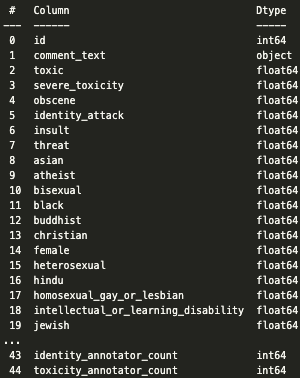

---

### 2. [MS2] After subsetting the data, less than 0.001% of the data was missing, so we dropped the missing data, as we deemed dropping it would be inconsequential.

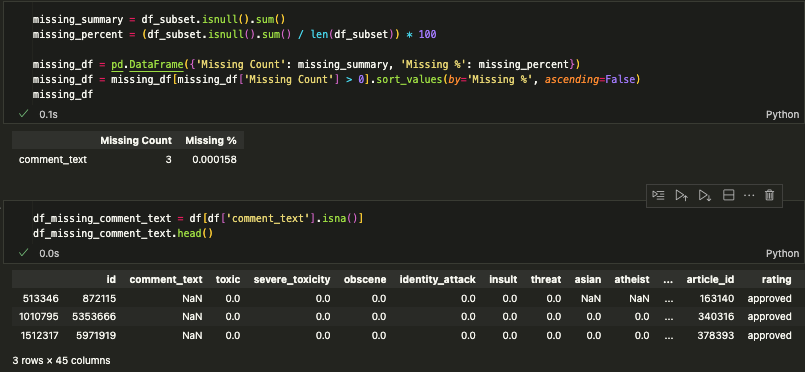

---

### 3. [MS2] Feature scaling is not necessary for our classification task—the input is text and the output is binary.

---

### 4. [MS2/MS3] We noticed a massive class imbalance, so we decided to upsample the comments with the `toxic` class.

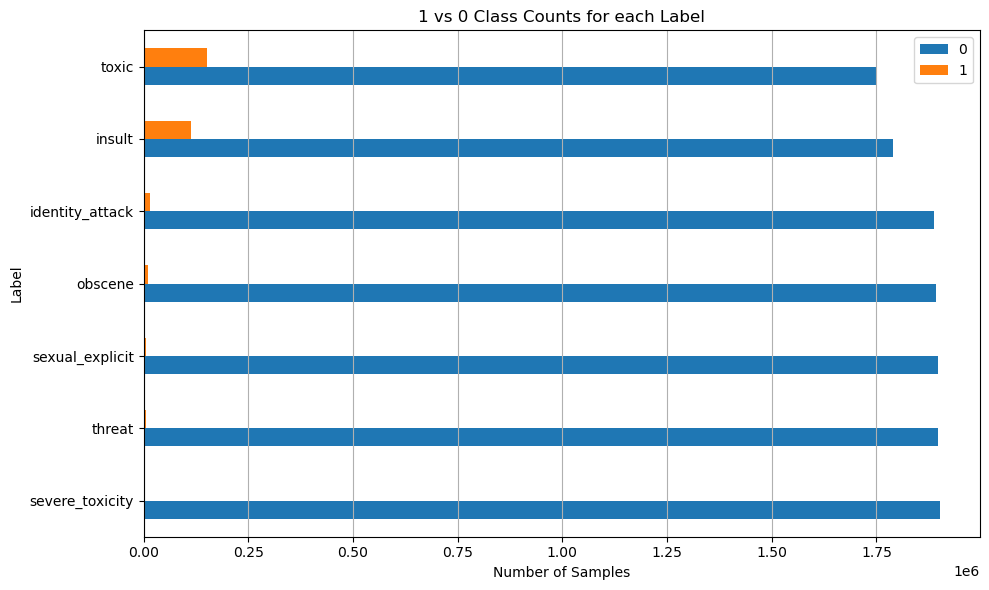

---

<a id="preprocess2"></a>

## Additional Preprocessing

[Return to contents](#contents)

##### We are going to start by combining the `severe_toxic` and `toxic` class

In [3]:
# Read the data
df = pd.read_csv("data/cleaned_ms2_data.csv")
df.head(3)

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,59848,"This is so cool. It's like, 'would you want yo...",0,0,0,0,0,0,0
1,59849,Thank you!! This would make my life a lot less...,0,0,0,0,0,0,0
2,59852,This is such an urgent design problem; kudos t...,0,0,0,0,0,0,0


In [4]:
# Combine toxic and severe_toxicity
df['toxic'] = df['toxic'] | df['severe_toxicity']
df = df.drop(columns=['severe_toxicity'])

In [5]:
# Hold out a stratified test set
X = df['comment_text']
y = df['toxic']
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=109,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.10,
    random_state=109,
    stratify=y_temp
)

# Reconstruct train‐frame
train_df = pd.DataFrame({'comment_text': X_train, 'toxic': y_train})
test_df = pd.DataFrame({'comment_text': X_test, 'toxic': y_test})
val_df = pd.DataFrame({'comment_text': X_val, 'toxic': y_val})

---

##### Upsample the `toxic` class in training set 

In [6]:
# Separate toxic and non-toxic comments
train_df = pd.DataFrame({'comment_text': X_train, 
                         'toxic': y_train})
tox = train_df[train_df.toxic == 1]
nontox = train_df[train_df.toxic == 0]

# Upsample the toxic class to match non-toxic size
tox_upsampled = resample(
    tox,
    replace=True,
    n_samples=len(nontox),
    random_state=109
)

train_balanced = pd.concat([nontox, tox_upsampled]).sample(frac=1, random_state=109)
train_balanced.toxic.value_counts()

toxic
0    1260056
1    1260056
Name: count, dtype: int64

##### The stage is now set for tokenization and to train the model!

<a id="model"></a>

# 3. Modeling
[Return to contents](#contents)

#### Final Optimal Model: DeBERTa 

[Question asks for: 
- Explain the choice of your baseline model, considering simplicity, interpretability, and relevance.
- Detail the training process, including preprocessing, parameters, and metrics used for evaluation.
- Present initial results, discussing alignment with expectations and project objectives]

We chose this as a baseline model for a few reasons:
- We used this in Lab 10 to help us with sentiment analysis, and we are doing an isomorphic problem
- using hugging face and pytorch pipeline for encoding datasets for use with pre-trained DeBERTa



Process:
1. Create hugginface Datasets from Dataframes
2. Tokenize and encode Datasets
3. Load the DeBERTa model from huggingface
4. Define our metrics
5. Define the Trainer
6. Train the model
7. Evaluate on our Test Dataset

In [ ]:
# 1) Create huggingface datasets from Dataframes above

train_ds = Dataset.from_pandas(train_balanced)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)


In [ ]:
# 2) Set up tokenizer and encode

model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_texts(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length=256)

encoded_train = train_ds.map(preprocess_function, batched=True)
encoded_val   = val_ds.map(preprocess_function, batched=True)
encoded_test  = test_ds.map(preprocess_function, batched=True)


In [1]:
# 3) Load the DeBERTa model from huggingface

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=1,  # logits for binary classification
    problem_type="single_label_classification"
)


NameError: name 'TFAutoModelForSequenceClassification' is not defined

#### ChatGPT helped me debug the tokenization problem I had (which was that I was passing a Series object into the tokenizer, instead of a string or list of strings

In [8]:
# # Tokenize each set
# def tokenize_texts(texts):
#     return tokenizer(
#         texts.tolist(),
#         padding=True,
#         truncation=True,
#         max_length=128,
#         return_tensors="tf"
#     )

# enc_train = tokenize_texts(X_train)
# enc_val   = tokenize_texts(X_val)
# enc_test  = tokenize_texts(X_test)

In [9]:
# # create my datasets
# train_ds = tf.data.Dataset.from_tensor_slices((dict(enc_train), y_train.values)) \
#                        .shuffle(10_000).batch(32)
# val_ds   = tf.data.Dataset.from_tensor_slices((dict(enc_val),   y_val.values)) \
#                        .batch(32)
# test_ds  = tf.data.Dataset.from_tensor_slices((dict(enc_test),  y_test.values)) \
#                        .batch(32)

In [11]:
# # For the purpose of this milestone, we are going to use significantly less data (helped by ChatGPT)
# def sample_balanced_dataset(dataset, n_per_class, batch_size=32, shuffle_buffer=None, seed=198):
#     """
#     Returns a smaller, balanced tf.data.Dataset by sampling n_per_class examples
#     from each class in the given dataset. The input dataset can be batched;
#     it will be unbatched first, then filtered, sampled, recombined,
#     optionally shuffled, and re-batched.
    
#     Args:
#         dataset: tf.data.Dataset yielding (features, label) pairs, where label is 0 or 1.
#         n_per_class: int, number of examples to sample for each class.
#         batch_size: int, the batch size for the returned dataset.
#         shuffle_buffer: int or None, buffer size for shuffling; if None, no shuffle applied.
#         seed: int, random seed for shuffle.
#     """
#     ds = dataset.unbatch()
#     pos = ds.filter(lambda x, y: tf.equal(y, 1)).take(n_per_class)
#     neg = ds.filter(lambda x, y: tf.equal(y, 0)).take(n_per_class)
#     small = pos.concatenate(neg)
#     if shuffle_buffer:
#         small = small.shuffle(shuffle_buffer, seed=seed)
#     return small.batch(batch_size)

In [ ]:
# # Create smaller datasets
# small_train_ds = sample_balanced_dataset(
#     train_ds, 
#     n_per_class=2000, 
#     batch_size=32, 
#     shuffle_buffer=4000
# )
# small_val_ds = sample_balanced_dataset(
#     val_ds, 
#     n_per_class=500, 
#     batch_size=32, 
#     shuffle_buffer=1000
# )
# small_test_ds = sample_balanced_dataset(
#     test_ds, 
#     n_per_class=500, 
#     batch_size=32, 
#     shuffle_buffer=1000
# )

In [13]:
# Borrowing Code from Lab 10
lr = 1e-5
epochs  = 5   # with early stopping, this is plenty

def scheduler(epoch, lr):
    warmup_epochs = 1
    decay_epochs  = epochs - warmup_epochs
    if epoch < warmup_epochs:
        return lr * (epoch + 1) / warmup_epochs
    else:
        return lr * (1 - (epoch - warmup_epochs) / decay_epochs)

# 2) Callbacks
checkpoint_filepath = "distilbert_best.weights.h5"
checkpoint_cb = ModelCheckpoint(
    "best.weights.h5",
    save_weights_only=True,
    monitor="val_AUPRC",
    mode="max",
    save_best_only=True
)

earlystop_cb = EarlyStopping(
    monitor="val_AUPRC",
    patience=2,
    restore_best_weights=True,
    verbose=1
)

lr_callback = LearningRateScheduler(scheduler, verbose=1)

In [14]:
# 4) Define our metrics

f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
accuracy_metric = evaluate.load("accuracy")
auprc_metric = evaluate.load("average_precision")  # area under PR curve

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy().flatten()
    preds = (probs > 0.5).astype(int)

    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels)["f1"],
        "precision": precision_metric.compute(predictions=preds, references=labels)["precision"],
        "recall": recall_metric.compute(predictions=preds, references=labels)["recall"],
        "auprc": auprc_metric.compute(prediction_scores=probs, references=labels)
    }


In [ ]:
# 5) Set up hugging face trainer

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="auprc",
    greater_is_better=True,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


In [ ]:
# 6) Train the Model
trainer.train()


In [ ]:
# 7) Evaluate on Test Set

results = trainer.evaluate(encoded_test)
print(results)


In [15]:
# # Build and compile
# loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-08)

# model.compile(
#     optimizer=optimizer,
#     loss=loss,
#     metrics=[
#         BinaryAccuracy(name="accuracy"),
#         Precision(name="precision"),
#         Recall(name="recall"),
#         F1Binary(),
#         auprc,
#         NormalizedEntropyBinary(baseline_ce)
#     ]
# )

In [16]:
# # Fit
# history = model.fit(
#     small_train_ds,
#     validation_data=small_val_ds,
#     epochs=5,
#     callbacks=[checkpoint_cb, earlystop_cb, lr_callback],
#     use_multiprocessing=True,
#     workers=-1
# )


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/5


2025-04-28 23:46:07.168601: I external/local_xla/xla/service/service.cc:168] XLA service 0x1522bcee4190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-28 23:46:07.168643: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-04-28 23:46:07.173619: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-28 23:46:07.204464: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1745898367.274662   13005 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    125/Unknown - 71s 421ms/step - loss: 0.5696 - accuracy: 0.6580 - precision: 0.8355 - recall: 0.3935 - f1_score: 0.7209 - AUPRC: 0.7652 - normalized_entropy: 2.0439

2025-04-28 23:47:04.945132: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 10032232857858061502
2025-04-28 23:47:04.945174: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 5978440184884096394
2025-04-28 23:47:04.945185: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 6051404552210482564
2025-04-28 23:47:04.945193: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 15104257664716974313
/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/site-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Binary implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/shared/courseSharedFolders/142601outer/142601/cs109b/lib/python3.11/si

125/125 [==============================] - 82s 507ms/step - loss: 0.5696 - accuracy: 0.6580 - precision: 0.8355 - recall: 0.3935 - f1_score: 0.7209 - AUPRC: 0.7652 - normalized_entropy: 2.0277 - val_loss: 0.3790 - val_accuracy: 0.8270 - val_precision: 0.9247 - val_recall: 0.7120 - val_f1_score: 0.8435 - val_AUPRC: 0.8853 - val_normalized_entropy: 1.3055 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 2/5
125/125 [==============================] - 57s 453ms/step - loss: 0.3585 - accuracy: 0.8493 - precision: 0.8782 - recall: 0.8110 - f1_score: 0.8557 - AUPRC: 0.8622 - normalized_entropy: 1.2866 - val_loss: 0.3266 - val_accuracy: 0.8580 - val_precision: 0.9182 - val_recall: 0.7860 - val_f1_score: 0.8604 - val_AUPRC: 0.8793 - val_normalized_entropy: 1.1848 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 7.499999810534064e-06.
Epoch 3/5
125/125 [==============================] - 57s 454ms/step - loss: 0.2943 -

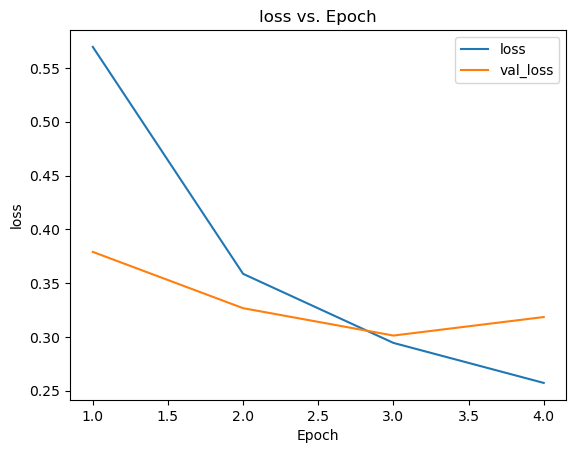

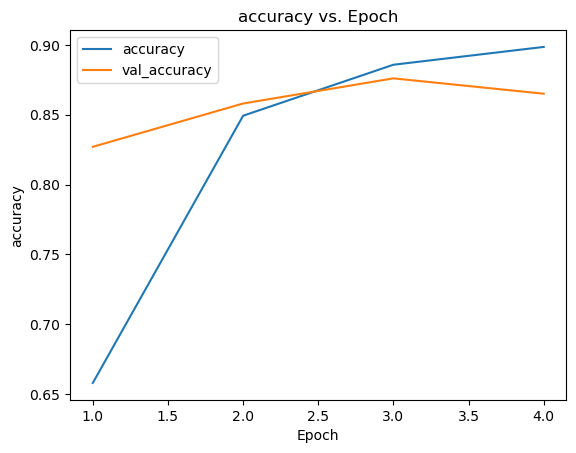

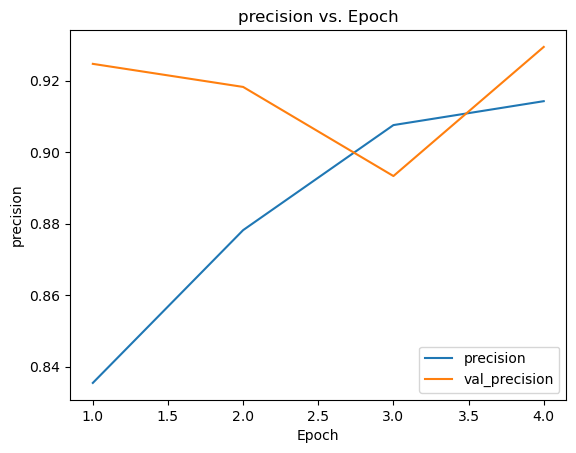

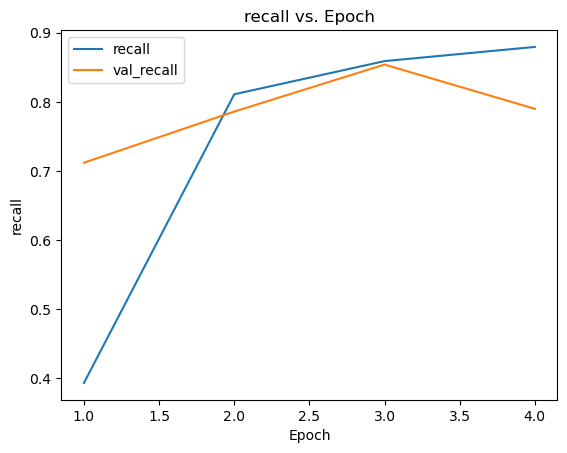

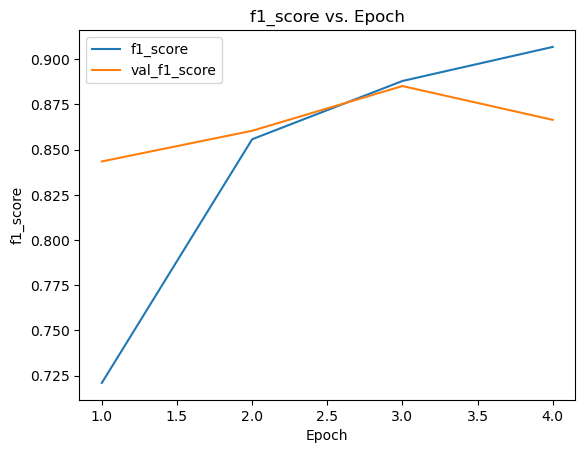

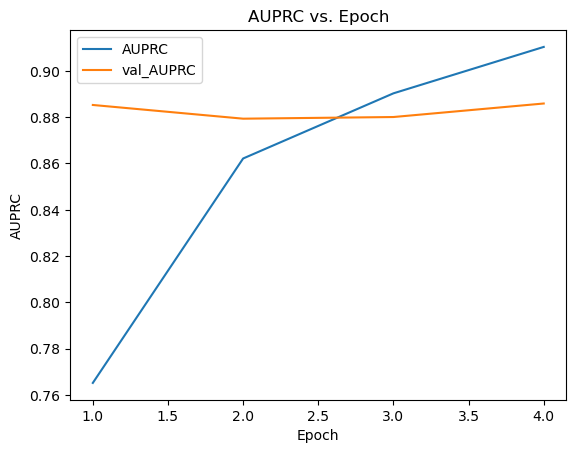

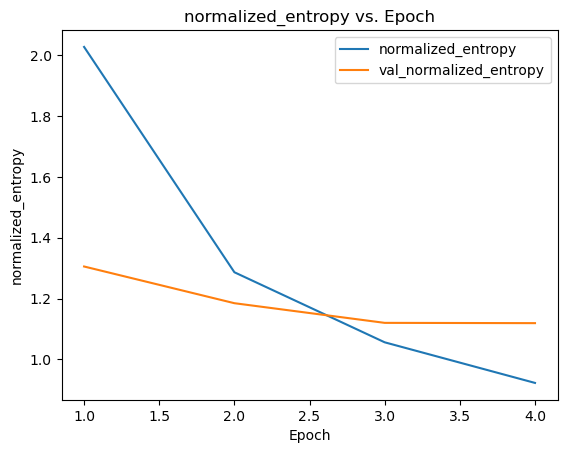

In [17]:
# Plot metrics vs. Epochs
hist = history.history
metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score', 'AUPRC', 'normalized_entropy']
epochs = range(1, len(hist['loss']) + 1)

for metric in metrics:
    plt.figure()
    plt.plot(epochs, hist[metric],      label=metric)
    plt.plot(epochs, hist[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(f'{metric} vs. Epoch')
    plt.legend()
    plt.show()


In [19]:
# Compare against the test_ds
results = model.evaluate(small_test_ds)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")


32/32 [==============================] - 6s 166ms/step - loss: 0.3523 - accuracy: 0.8420 - precision: 0.8904 - recall: 0.7800 - f1_score: 0.8453 - AUPRC: 0.8597 - normalized_entropy: 1.2711
loss: 0.3523
accuracy: 0.8420
precision: 0.8904
recall: 0.7800
f1_score: 0.8453
AUPRC: 0.8597
normalized_entropy: 1.2711


2025-04-29 00:02:42.325618: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 4242305282633219075
2025-04-29 00:02:42.325651: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 13409307579201173463


<a id="choice"></a>

## Baseline Model Choice
[Return to contents](#contents)

For our baseline model, we selected DistilBERT, prioritizing a balance of simplicity, interpretability, and relevance to our task. We previously used DistilBERT in Lab 10 for sentiment analysis — a task structurally similar to our project — which reinforced its applicability to this classification setting.

As a lighter and faster derivative of BERT, DistilBERT retains approximately 95% of BERT’s performance while using only 50% of the parameters, enabling faster training and inference. This efficiency allows us to rapidly evaluate model viability on our dataset without prematurely committing extensive computational resources. Moreover, because DistilBERT preserves core BERT design principles — such as bidirectional encoding, rectangular padded/truncated input representations, and compatibility with limited-sample settings — it provides a proxy for the behaviors of larger transformer models.

Using DistilBERT gives us confidence that strong baseline results will generalize when we transition to more powerful architectures (e.g., DeBERTa or larger LLMs) in the final stages of our project. Our final model plans are discussed in more depth in Section 5.


<a id="train"></a>

## Training Process
[Return to contents](#contents)

**1. Model and Tokenizer Initialization**
We initialized the pretrained DistilBERT model and its corresponding tokenizer from the HuggingFace transformers library. This ensured compatibility between text preprocessing and model input expectations.

**2. Tokenization of Datasets**
Each of our data splits (training, validation, and test) was tokenized individually using the DistilBERT tokenizer. Inputs were padded and truncated to a uniform maximum sequence length to enable efficient batch processing.

**3. Tensor Dataset Creation**
We converted the tokenized outputs into TensorFlow tensor datasets, aligning token IDs, attention masks, and target labels for supervised learning.

**4. Dataset Optimization: Sampling, Batching, and Buffering**
To accelerate training, we applied sampling, batching, and prefetch buffering techniques:

- Shuffled the training dataset
- Batched into mini-batches of fixed size (32)
- Prefetched buffered batches to improve GPU utilization

**5. Training Configuration**
We trained the model for 5 epochs, using an appropriate learning rate scheduler and early stopping based on validation AUPRC (Area Under the Precision-Recall Curve).
This allowed us to optimize training duration while avoiding overfitting.

**6. Custom Metrics Definition**
We implemented custom evaluation metrics:

- F1 Score for binary classification
- Normalized Entropy to measure output uncertainty
- SupRC (smoothed AUPRC) for stability
- A custom binary F1 score function compatible with DistilBERT’s raw logits output

**7. Model Compilation**
We compiled the model with:

- Binary Cross-Entropy loss function
- Adam optimizer with an adaptive learning rate
- These choices aligned with best practices for binary classification tasks using transformer models.

**8. Training Execution**
We executed the training loop, recording the history of loss and evaluation metrics across epochs for further analysis and model selection.

<a id="result"></a>

## Initial Results
[Return to contents](#contents)

We were happy with the training speed and overall performance / results of our baseline model, as we were able to train within minutes, as desired, and this proved our baseline model is directionally correct and should be useful . See further analysis of our results in Section 4 and commentary on "upgrades" for MS5 in Section 5.

<a id="interp"></a>

# 4. Results Interpretation & Analysis
[Return to contents](#contents)

**Summary**
Our DistilBERT baseline model demonstrates strong learning behavior across all major performance metrics. Training and validation losses decrease smoothly, while accuracy, F1 score, and AUPRC improve significantly over time. Precision and recall both reach high levels (>85%), with only minor tradeoffs emerging after the second epoch. Normalized entropy declines steadily, reflecting increasing confidence in model predictions. Together, these results suggest that DistilBERT is a highly effective baseline for our classification task, providing both strong predictive power and robust generalization to the validation set.  We used early-stopping after 2 epochs, but with a slightly larger sample size, smaller batch sizes, and longer epochs, it's possible we could improve performance and generalization even further (at the expense of training time) as indicated by the metric trends (see individual writeups below).  In any case, this is a solid baseline model which bodes well for our final optimized MS5 model.

<a id="analysis"></a>

## Analysis of Baseline Model Performance
[Return to contents](#contents)

**Loss vs. Epoch**
Both training and validation loss decrease steadily across epochs, with no signs of divergence. This indicates that the model is effectively learning without significant overfitting during early training.

**Accuracy vs. Epoch**
Training and validation accuracy both improve consistently over time, reaching nearly 88%. The validation accuracy slightly leads training accuracy, suggesting that the model generalizes well to unseen data without overfitting.

**Precision vs. Epoch**
Precision improves steadily for the training set and initially increases for the validation set before slightly declining after epoch 2. This suggests that while the model becomes more confident in its positive predictions, minor tradeoffs between precision and recall may start to emerge.

**Recall vs. Epoch**
Recall improves substantially across epochs for the training set and remains relatively high and stable for the validation set. This shows the model's increasing ability to correctly identify positive cases.

**F1 Score vs. Epoch**
F1 score, which balances precision and recall, shows a strong upward trend for both training and validation sets. The convergence around epoch 3 indicates robust and balanced model performance between false positives and false negatives.

**AUPRC vs. Epoch**
Area Under the Precision-Recall Curve (AUPRC) improves meaningfully across training and validation, peaking around epoch 2-3. The slight dip in validation AUPRC after epoch 2 suggests that optimal performance might be achieved slightly before full training completion.

**Normalized Entropy vs. Epoch**
Normalized entropy decreases over time, implying that the model's prediction confidence improves across epochs. Lower entropy suggests that the model's output probabilities are becoming more decisive and less uncertain.

<a id="improve"></a>

## Proposed Improvements
[Return to contents](#contents)

- More Epochs
- Higher Patience for Callbacks
- Use more of the data
- Smaller batches
- Use a GPT/LLM to generate more variety in the toxic comments

<a id="final"></a>

# 5. Final Model Pipeline
[Return to contents](#contents)

**Data Augmentation**

Data augmentation could be a key component to address data imbalance. We could get a GPT to rewrite the toxic comments while adhering the following rules:
- Rewrite it with different grammar, tones, emoji uses, etc.
- Swap identity terms - as we learned in class, this could help with fairness

We might be able to generate 5~10 different samples from one sample. This would increase the size of our dataset and help address data imbalance in a more nuanced way.

<a id="assum"></a>

## Assumptions, Parameter Choices, and Preliminary Tuning Considerations
[Return to contents](#contents)

**Modeling Parameter Choices & Tuning Considerations**
    
DistilBERT remains one of the best models for text classification because of its attention-based mechanism. Sometimes, people have also tried fine tuning large LLMs for classification task. However, there are several model sizes we could choose from. Larger models take more computing resources to train, and it’s more difficult for them to converge. Given the limited computing resources we have (L4 GPU cluster at Harvard), there are several choices we can make:

Train one large model (e.g. Fine-tuning DeBERTa-large, a 400M parameter model, or even finetune larger LLMs)
- Pros: Potentially higher performance potential
- Cons: might not be able to fully train the model with full precision.

Solutions:
- Mixed precision training
- LoRA adapter training for BERT
- [Stretch Goal / Optional] If we are able to get multiple GPUs for training, there are ways to run distributed training
- Pytorch FSDP which supports data parallelism training. Model’s weights and data are sharded across multiple GPUs
- Train a smaller model (e.g. DistilBERT, Roberta-base)

- Pros: easier to train because model could fit into 1 GPU
- Cons: These models have lower baseline performance on SquaD, etc. to begin with and may have lower performance ceiling than larger models.

The final decision we make regarding model size would depend on how large the dataset is (after data augmentation), how well we could build the model training pipeline to support larger models, and performance comparisons between training larger models with lower precision and smaller models with higher precision.

In terms of hyper-parameters, we could use the ones that are commonly used in the industry. For example, for DistilBert we could try:
- AdamW with LR = 2e-5
- Linear / Cosine decay
- Batch size of 32-128
- 3~5 epochs

We could do hyperparameter grid search, but because the model might take a long time to train we might focus our search on a smaller set of parameters and keep them fixed in the main training process.

**Assumptions (ran out of time to flesh this out fully)**
- This model has room for improvment
- Training on the entire dataset will yield improvements